For more explanation please refer to "Estrus" Notebook [Link](https://github.com/winuthayanon/estrus) 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import glob
import bbknn

In [2]:
sc.settings.verbosity = 3  
sc.logging.print_header() 
sc.settings.set_figure_params(dpi=80) 

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
import os.path
if os.path.isfile('./MM20567.loom'):
    print ("MM20567.loom exist")
else:
    !wget -c https://www.winuthayanon.com/share/looms-published/MM20567.loom

MM20567.loom exist


In [4]:
Human = sc.read_loom('./MM20567.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
Human.var_names_make_unique()  

In [6]:
Human

AnnData object with n_obs × n_vars = 7318 × 33538
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

normalizing counts per cell
    finished (0:00:00)


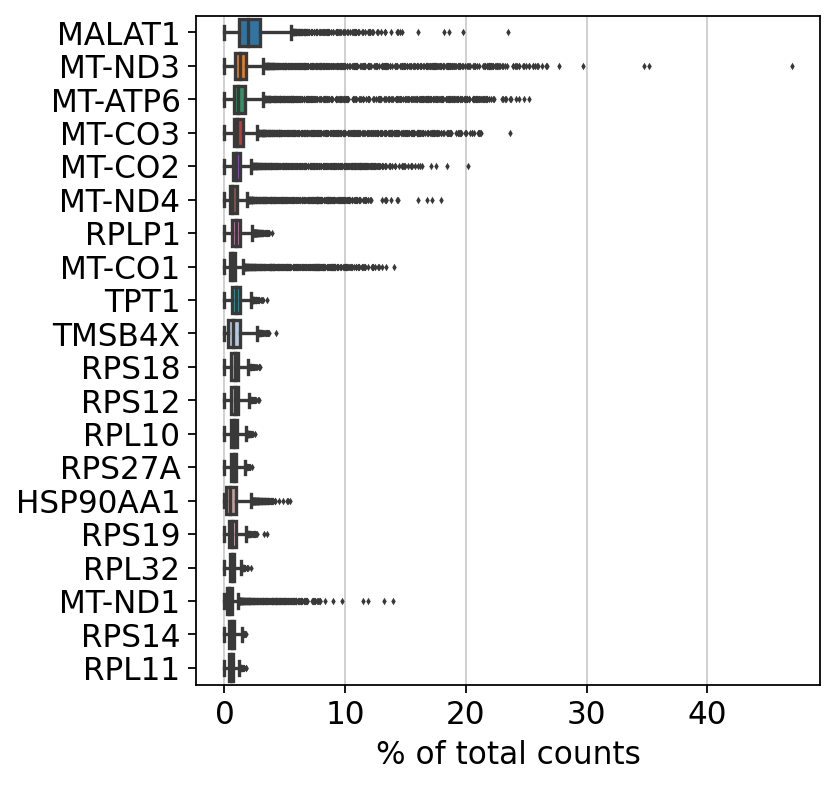

In [7]:
sc.pl.highest_expr_genes(Human, n_top=20)

In [8]:
sc.pp.filter_cells(Human, min_genes=200) 
sc.pp.filter_genes(Human, min_cells=3)

filtered out 220 cells that have less than 200 genes expressed
filtered out 13475 genes that are detected in less than 3 cells


'MT' for human data, 'mt' for mouse data

In [9]:
mito_genes = Human.var_names.str.startswith('MT-') 
Human.obs['percent_mito'] = np.sum(
    Human[:, mito_genes].X, axis=1).A1 / np.sum(Human.X, axis=1).A1 
Human.obs['n_counts'] = Human.X.sum(axis=1).A1 

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


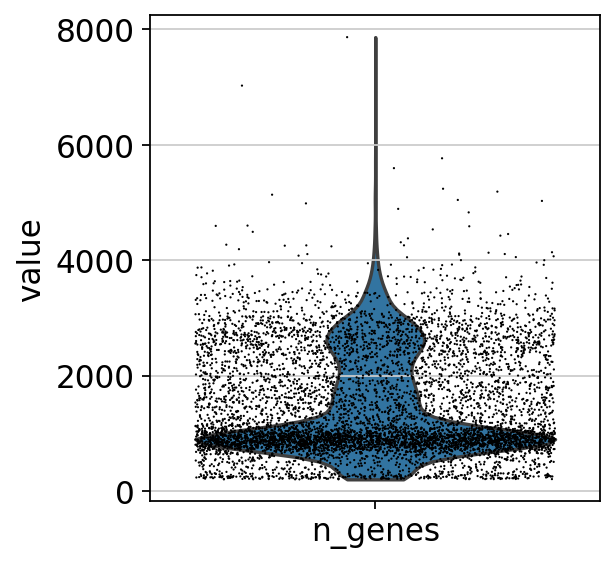

/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


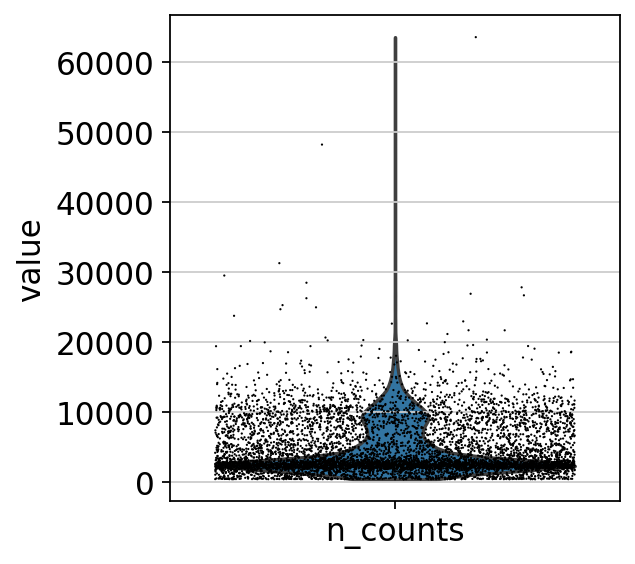

/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/envs/hub_v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


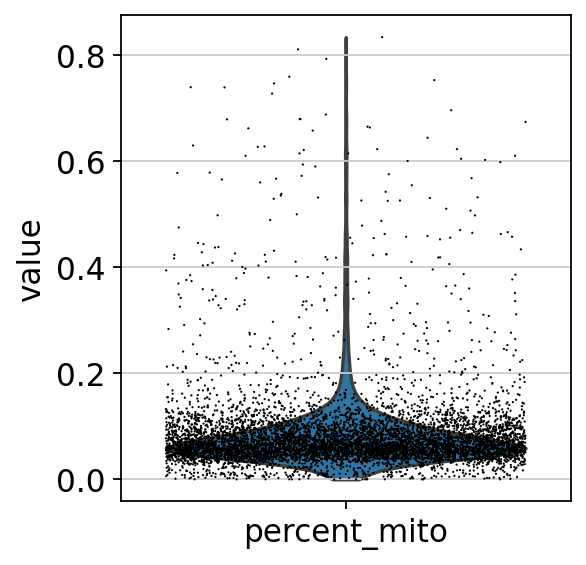

In [10]:
sc.pl.violin(Human, ['n_genes'], jitter=0.4)
sc.pl.violin(Human, ['n_counts'], jitter=0.4)
sc.pl.violin(Human, ['percent_mito'], jitter=0.4)

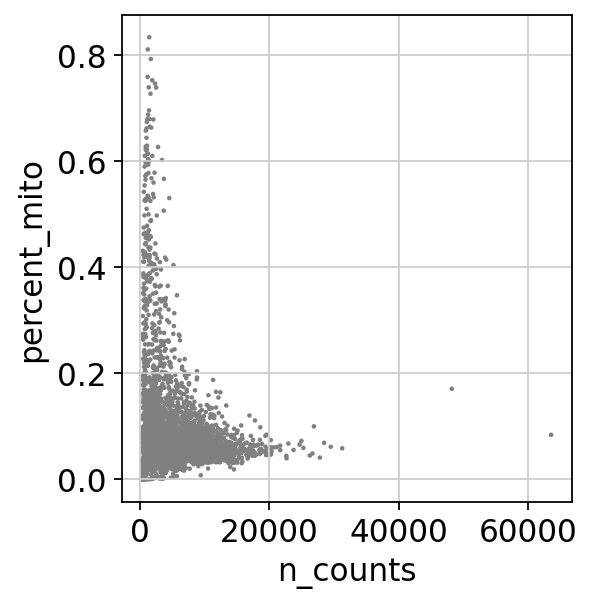

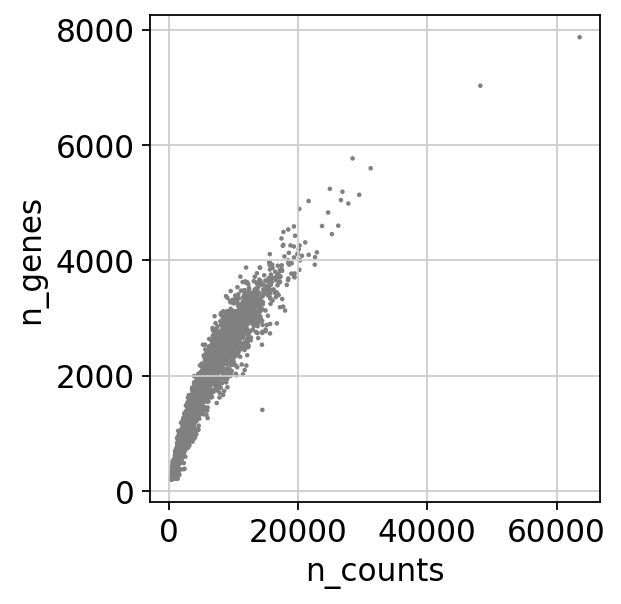

In [11]:
sc.pl.scatter(Human, x='n_counts', y='percent_mito')
sc.pl.scatter(Human, x='n_counts', y='n_genes')

In [12]:
Human = Human[Human.obs.n_genes < 6000, :]
Human = Human[Human.obs.percent_mito < 0.05, :]

In [13]:
Human.write('./Human.h5ad')

In [14]:
sc.pp.normalize_total(Human, target_sum = None)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/envs/hub_v2/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(Human)

In [16]:
sc.pp.filter_genes(Human, min_counts=3) 

filtered out 5135 genes that are detected in less than 3 counts


In [17]:
sc.pp.regress_out(Human, ['n_counts', 'percent_mito']) 

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:21)


In [18]:
sc.pp.highly_variable_genes(Human, n_top_genes=5000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


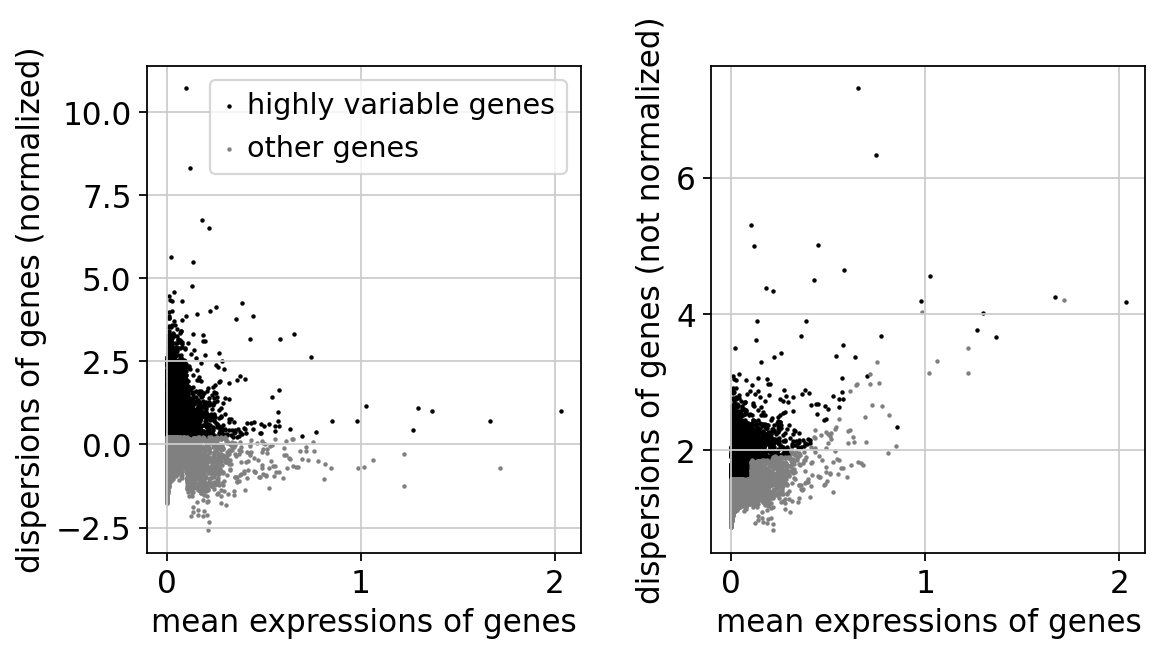

In [19]:
sc.pl.highly_variable_genes(Human)

In [20]:
sc.pp.scale(Human, max_value=10) 

In [21]:
sc.tl.pca(Human, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


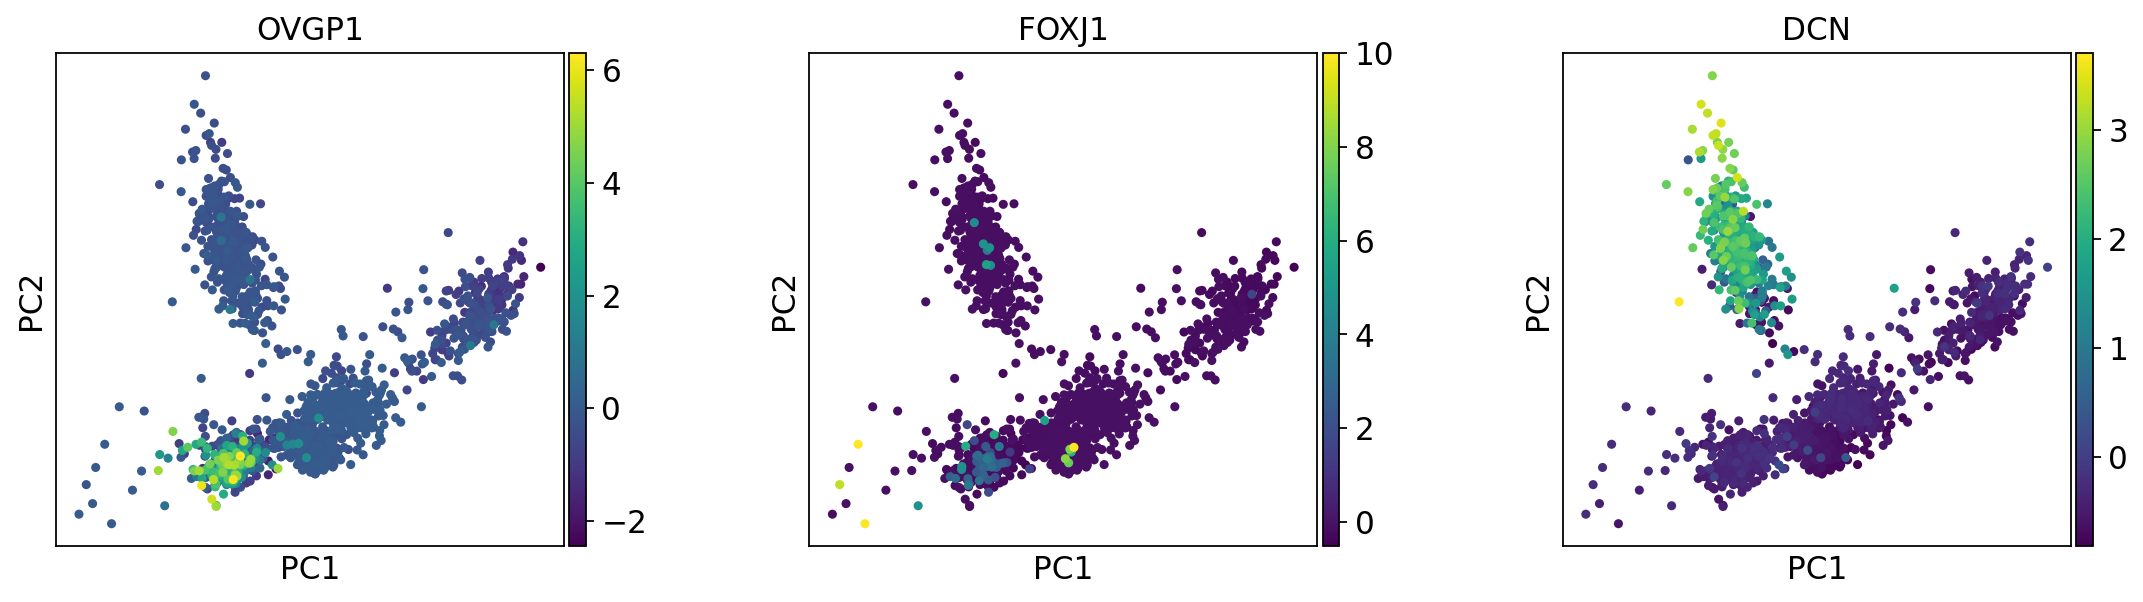

In [22]:
sc.pl.pca(Human, wspace=0.35,
          color=['OVGP1', 'FOXJ1',
                  'DCN'], save='_Human.pdf')

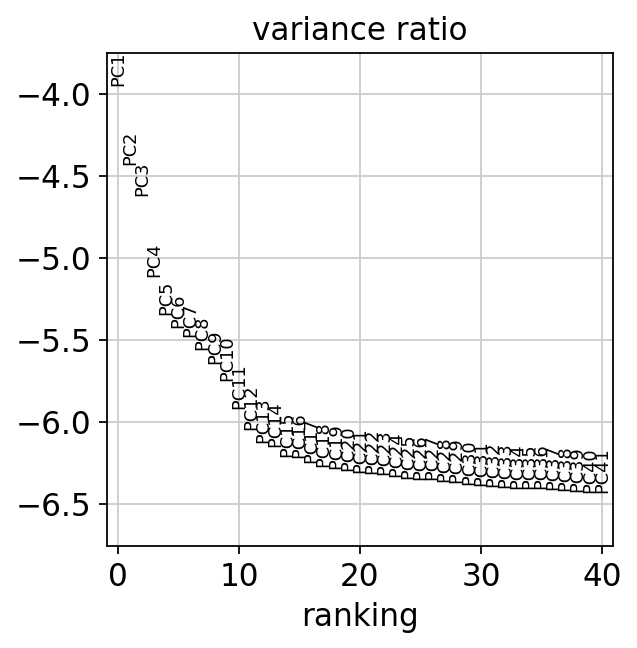

In [23]:
sc.pl.pca_variance_ratio(Human, n_pcs=40, log=True)

In [24]:
Human

AnnData object with n_obs × n_vars = 1790 × 14928
    obs: 'Clusters', '_X', '_Y', 'n_genes', 'percent_mito', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [25]:
sc.pp.neighbors(Human, n_neighbors=10, n_pcs=37)

computing neighbors
    using 'X_pca' with n_pcs = 37
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [26]:
sc.tl.umap(Human)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


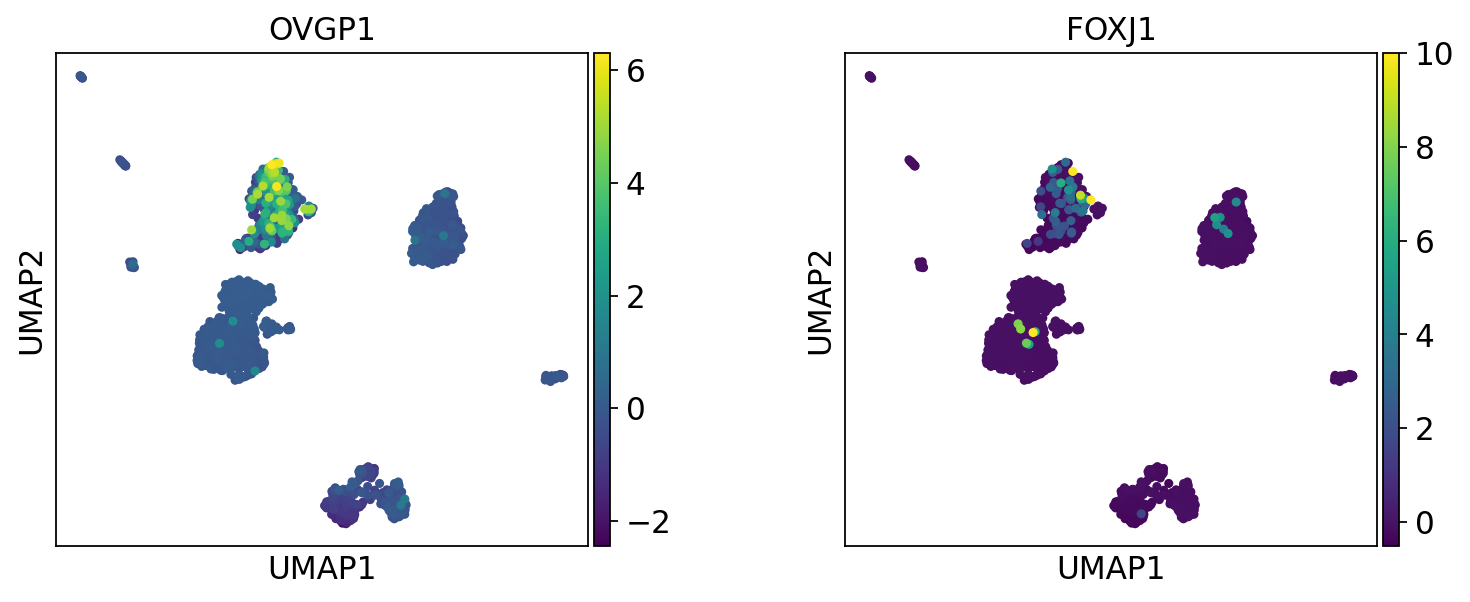

In [27]:
sc.pl.umap(Human, wspace=0.35,
           color=['OVGP1', 'FOXJ1'])

In [28]:
sc.tl.leiden(Human, resolution=0.5) 

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


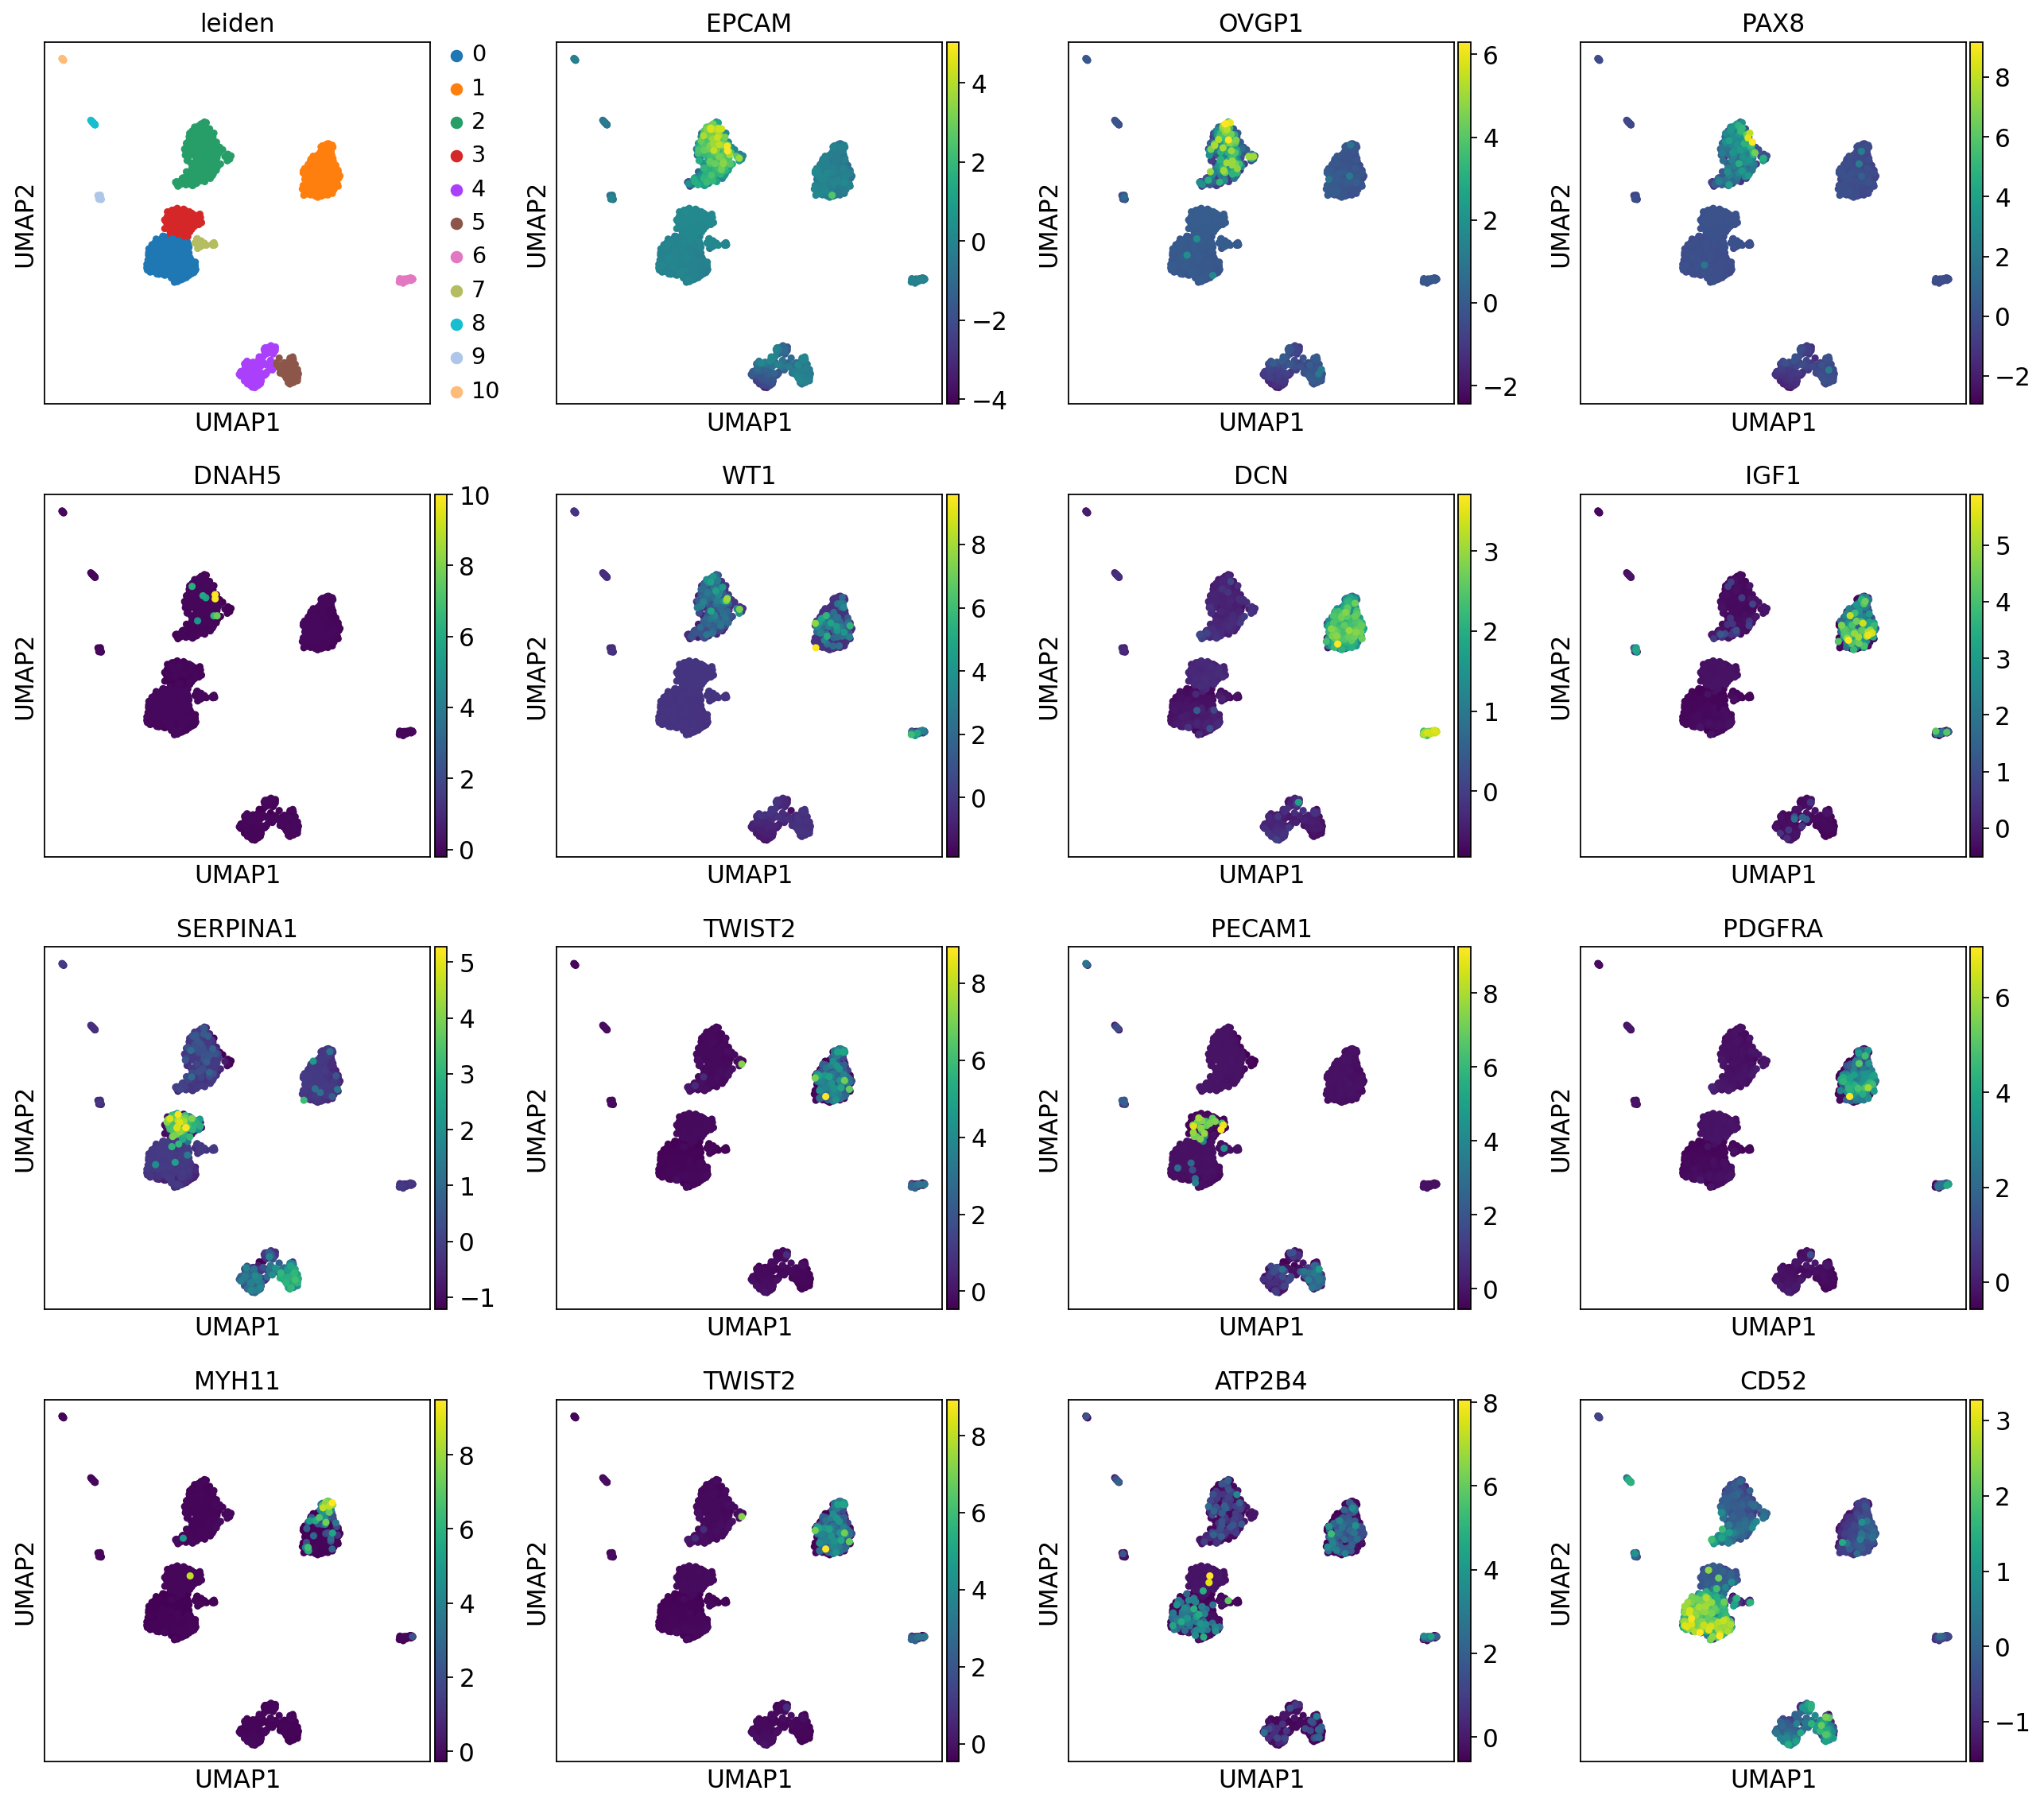

In [29]:
sc.pl.umap(Human,
           color=['leiden', 'EPCAM', 'OVGP1', 'PAX8', 'DNAH5', 'WT1', 
                  'DCN', 'IGF1', 'SERPINA1',
                  'TWIST2', 'PECAM1', 'PDGFRA', 'MYH11', 'TWIST2',
                  'ATP2B4', 'CD52'], 
          save='_Fallopiantube_leiden_markers.pdf')

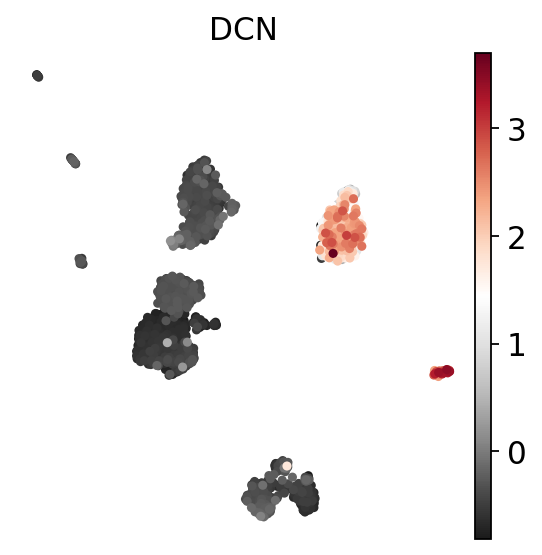

In [30]:
sc.pl.umap(Human,
           color=['DCN'], frameon=False, color_map='RdGy_r',
          save='_Fallopiantube_DCN.pdf')

In [31]:
!pwd

/home/scrna/data/Human


In [32]:
Human.obs.groupby(["leiden"]).apply(len)

leiden
0     450
1     382
2     375
3     240
4     138
5     102
6      31
7      30
8      18
9      15
10      9
dtype: int64

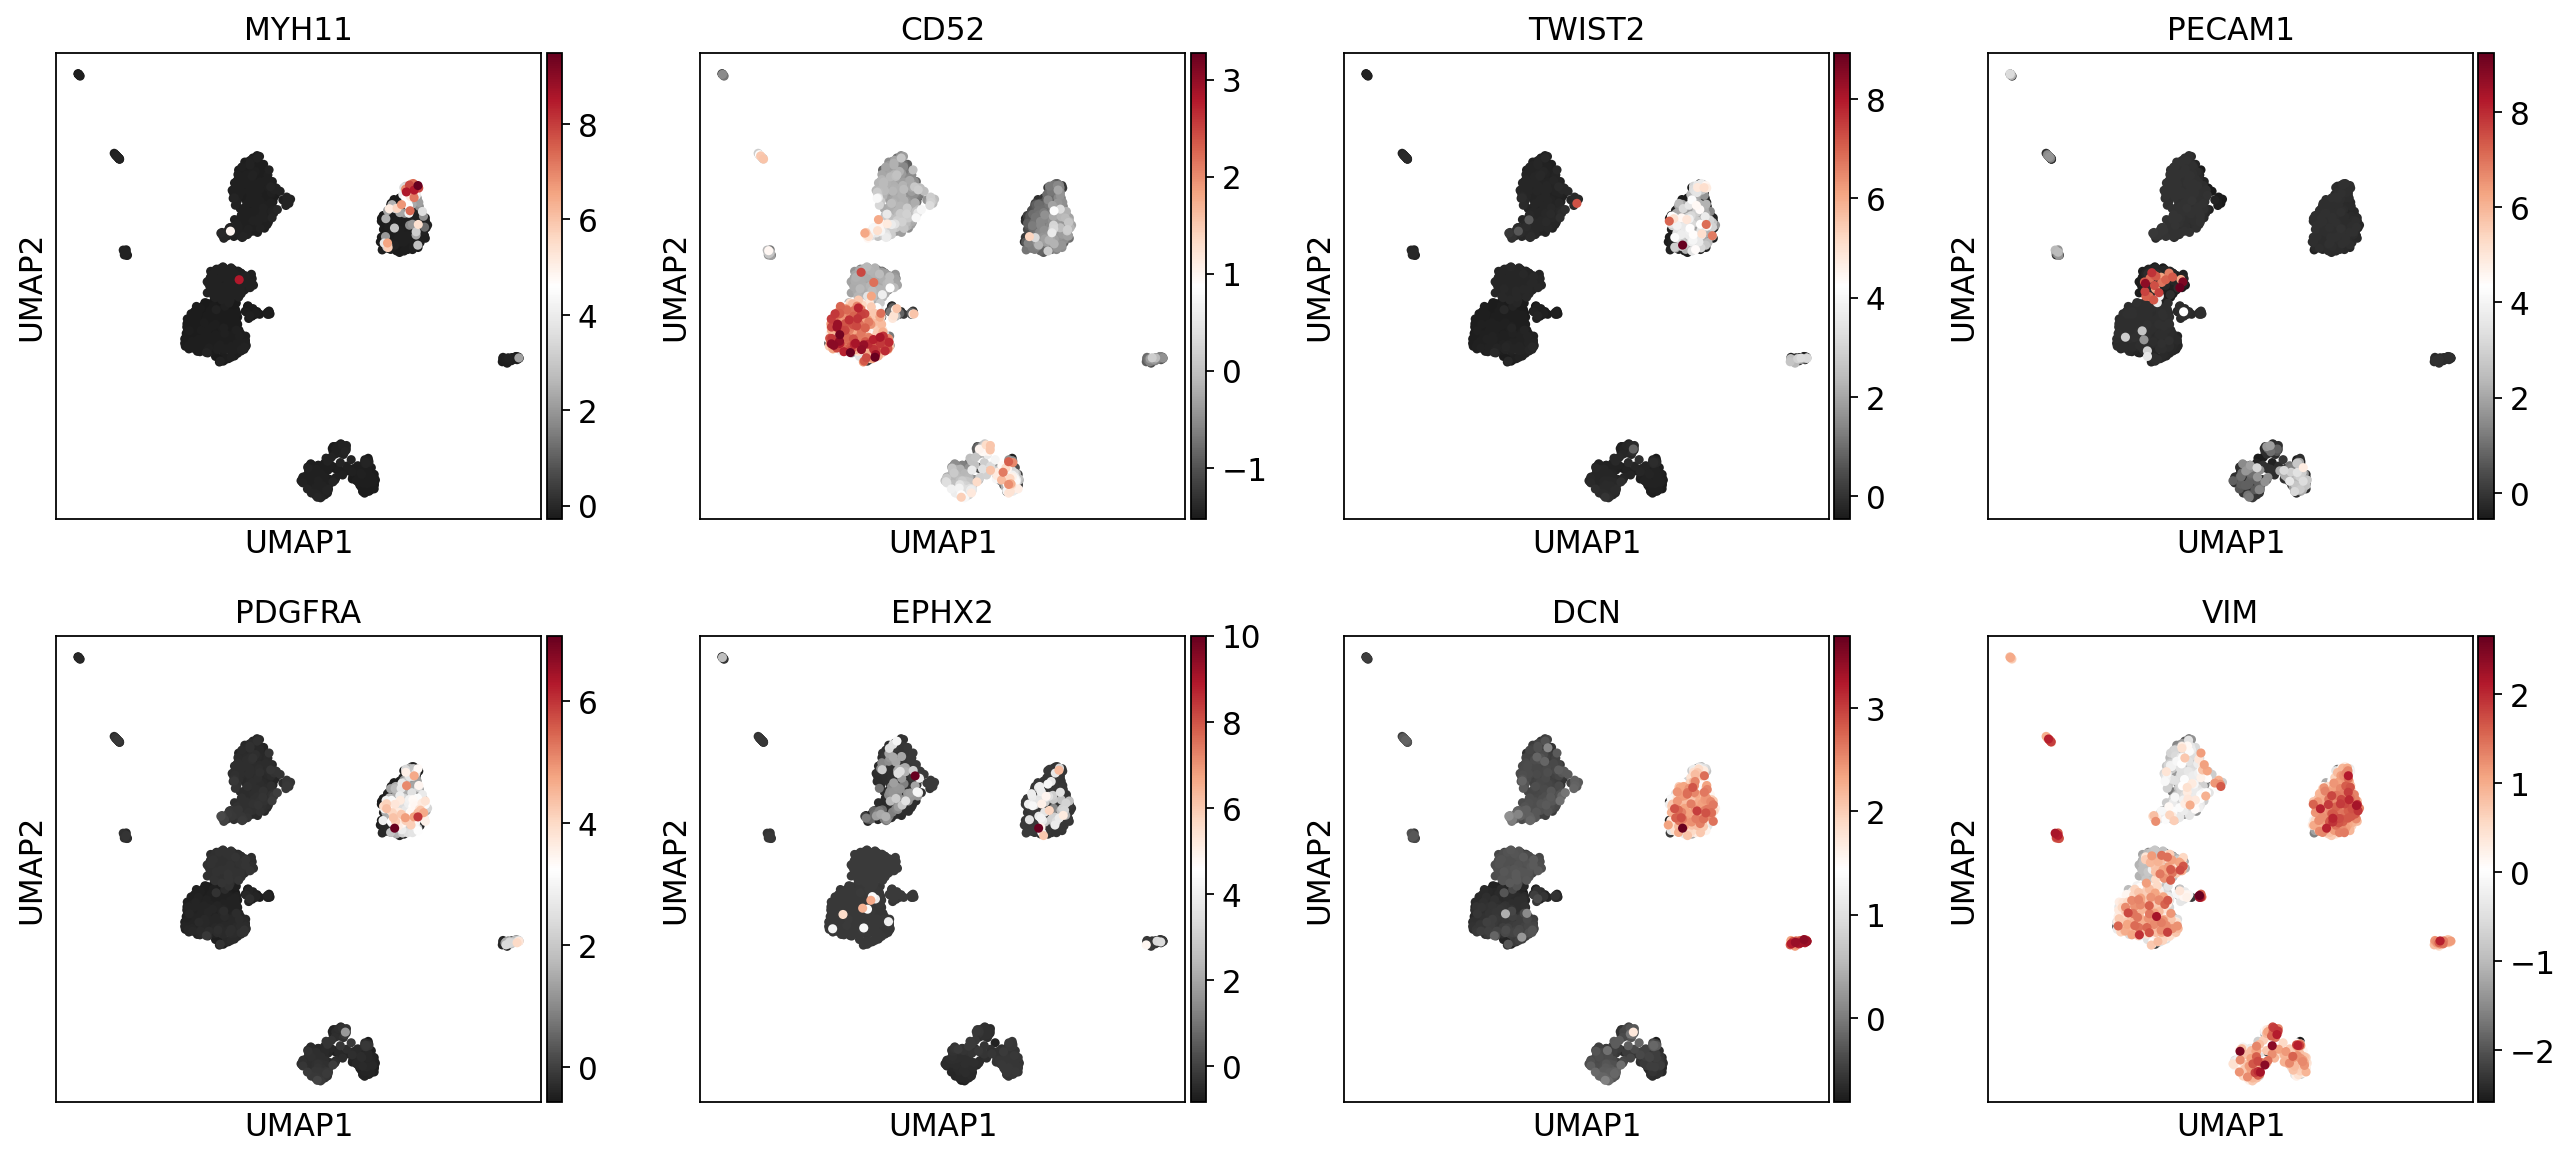

In [33]:
sc.pl.umap(Human, 
           color=['MYH11', 'CD52', 'TWIST2', 'PECAM1',
                  'PDGFRA', 'EPHX2', 'DCN', 'VIM'], color_map='RdGy_r')

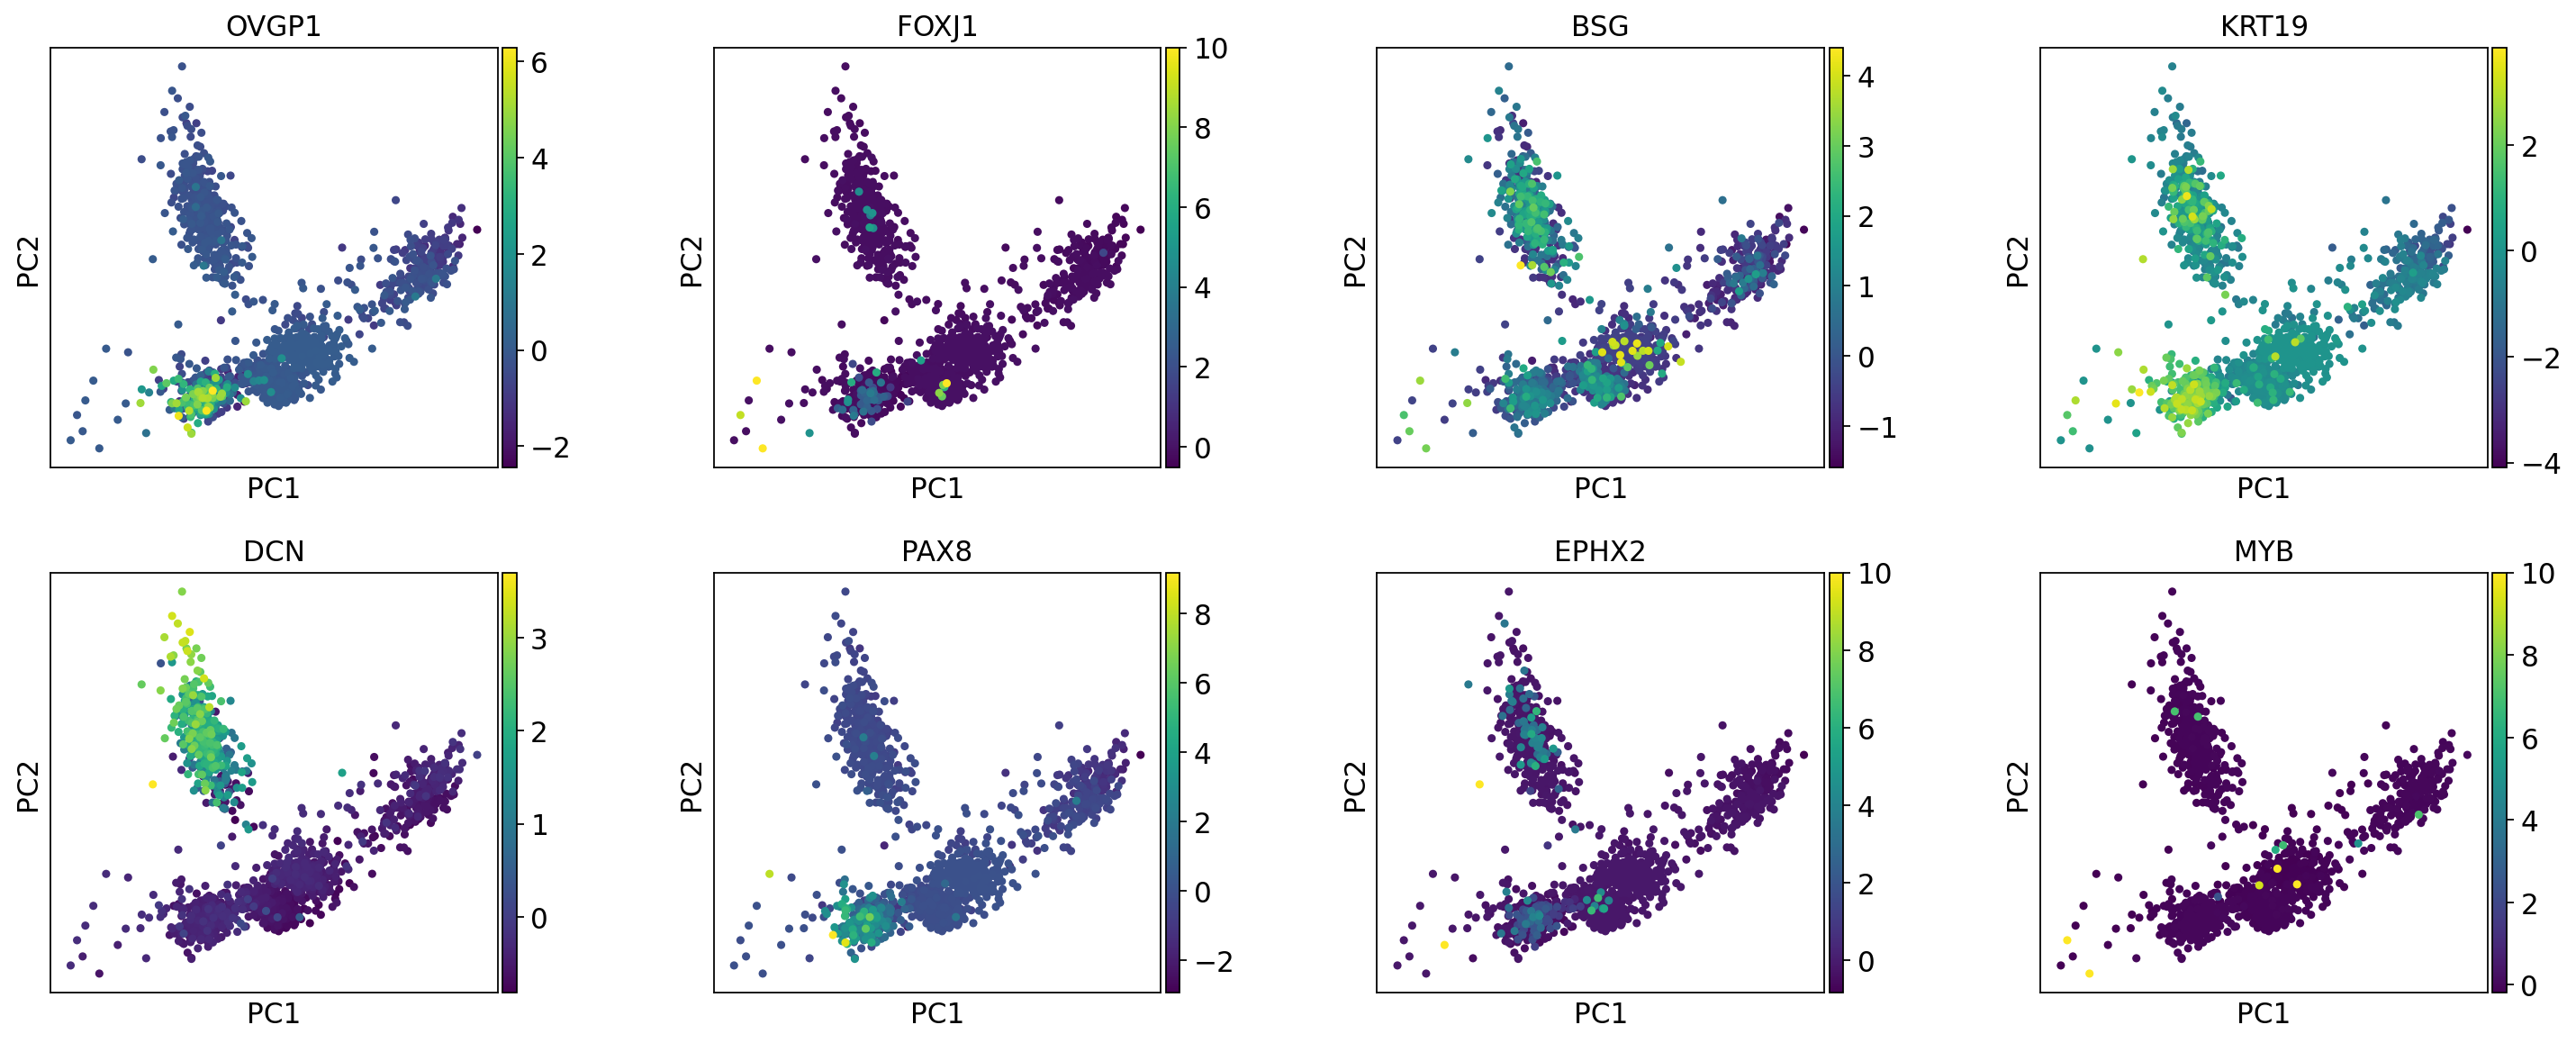

In [34]:
sc.pl.pca(Human, wspace=0.35,
          color=['OVGP1', 'FOXJ1', 'BSG',
                 'KRT19', 'DCN', 'PAX8', 'EPHX2', 'MYB'])

In [35]:
sc.tl.umap(Human)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/opt/conda/envs/hub_v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


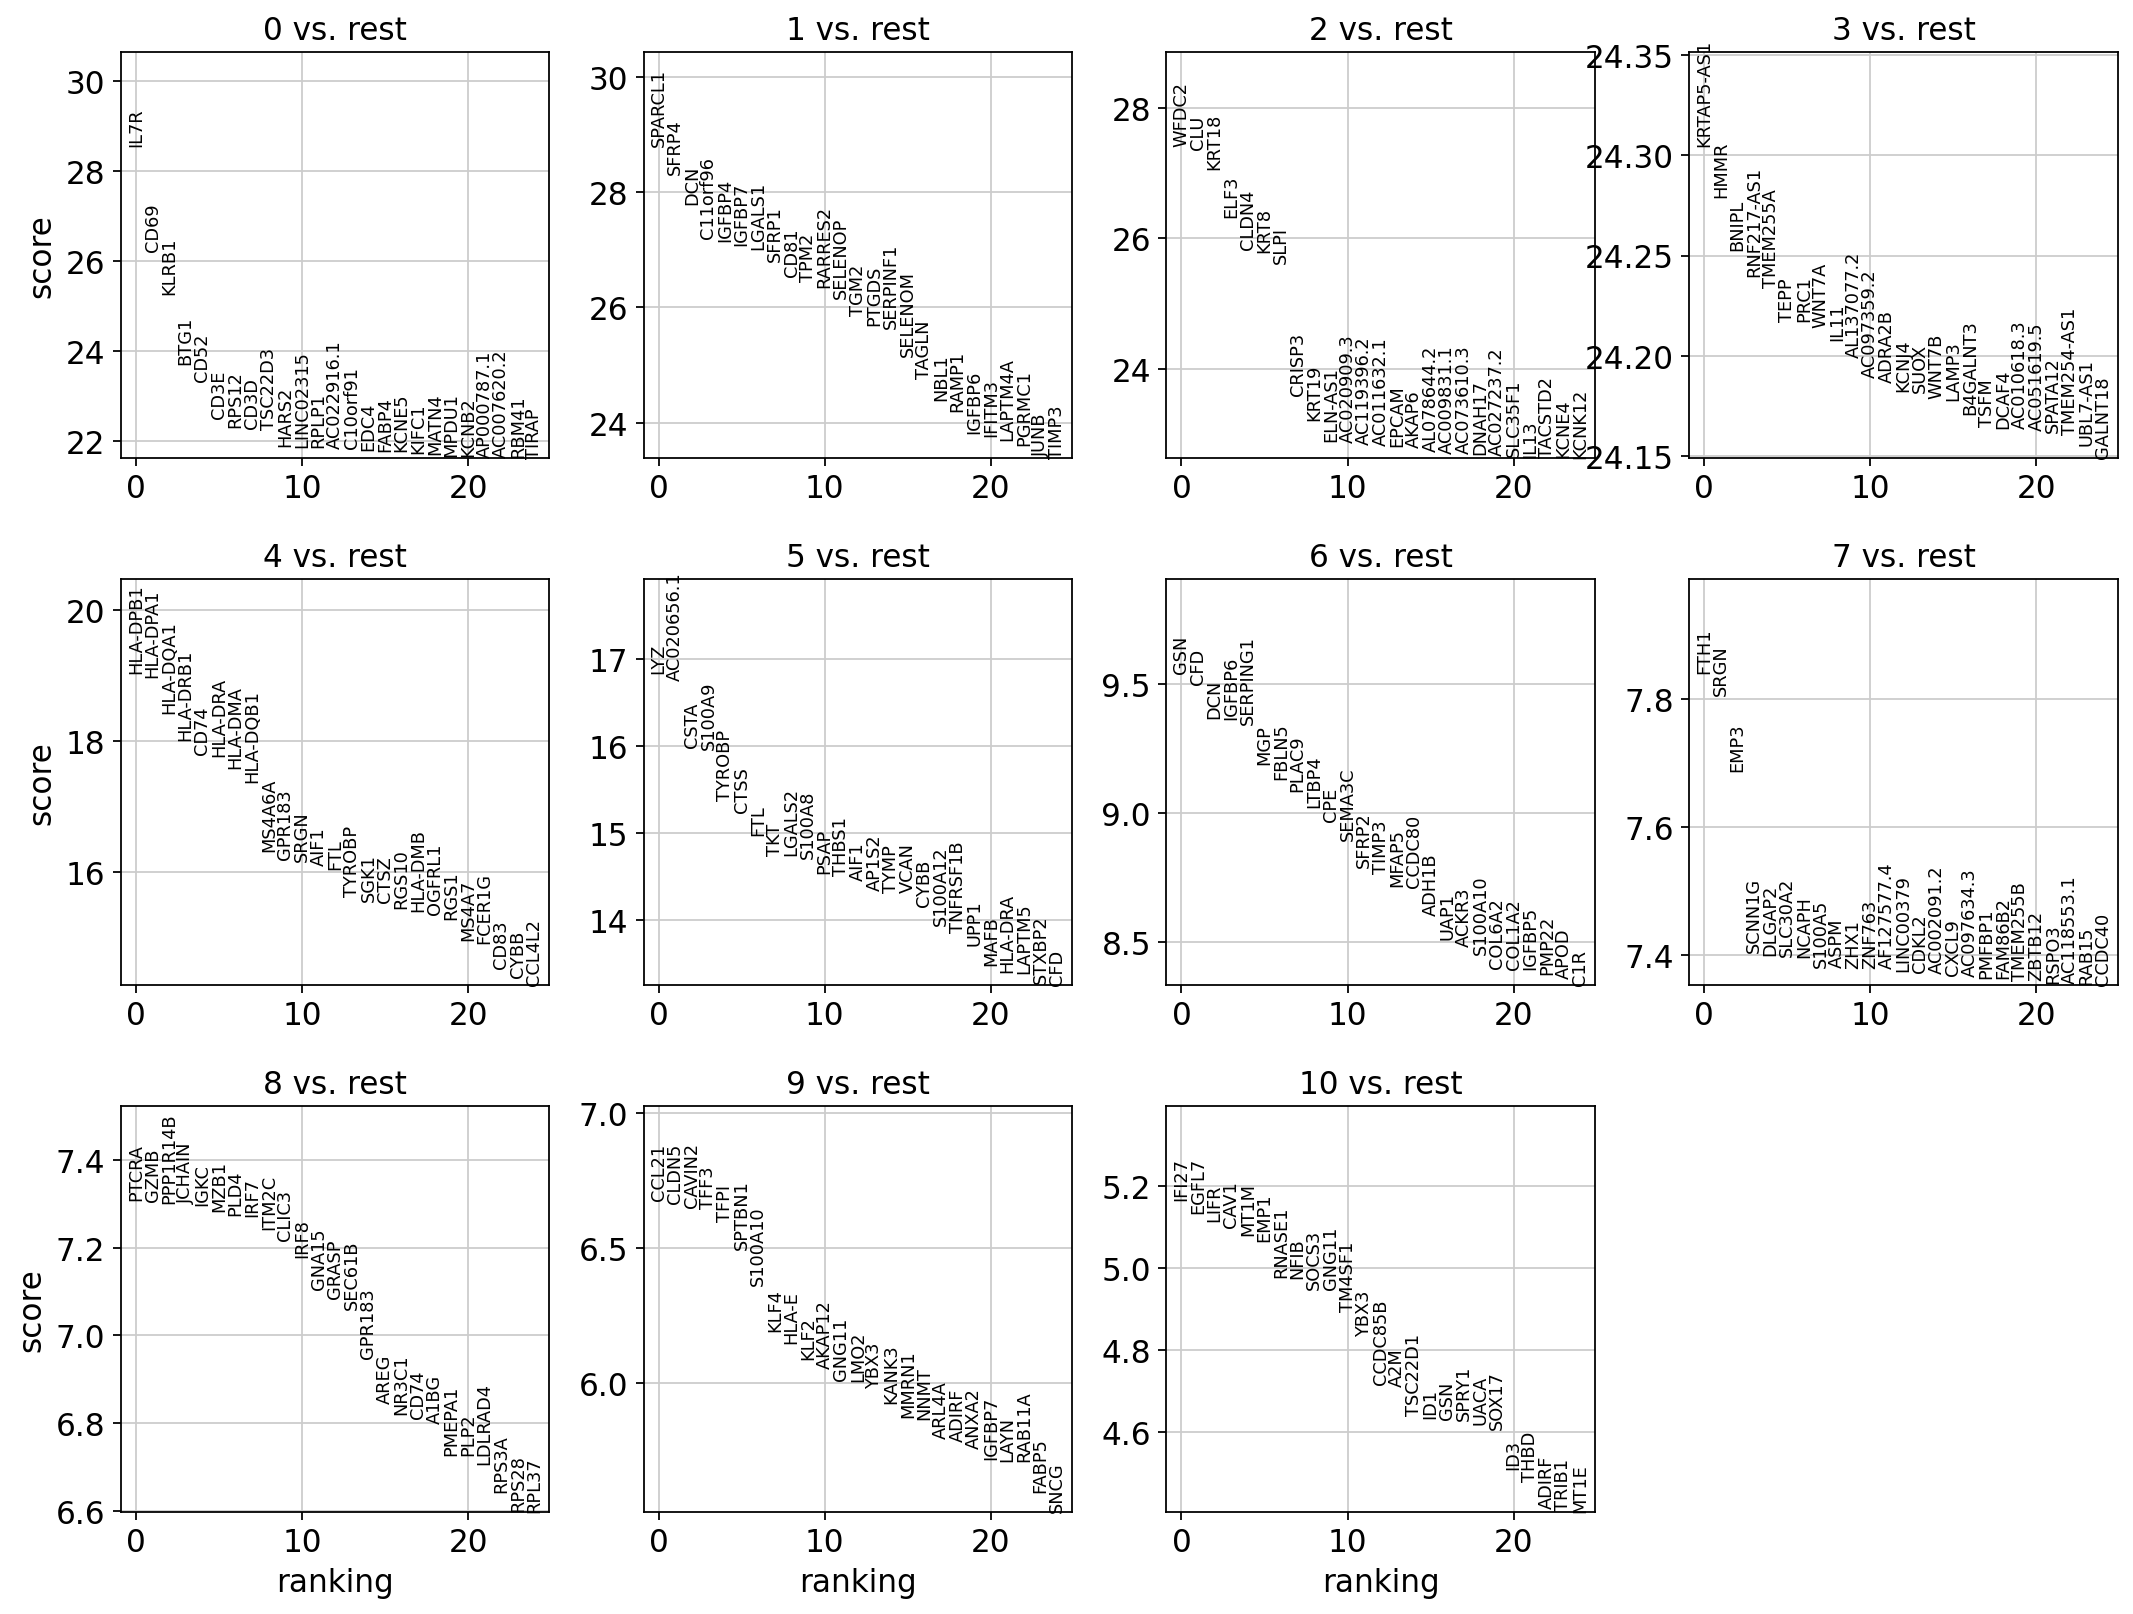

0         1      2           3         4           5         6       7  \
0   IL7R   SPARCL1  WFDC2  KRTAP5-AS1  HLA-DPB1         LYZ       GSN    FTH1   
1   CD69     SFRP4    CLU        HMMR  HLA-DPA1  AC020656.1       CFD    SRGN   
2  KLRB1       DCN  KRT18       BNIPL  HLA-DQA1        CSTA       DCN    EMP3   
3   BTG1  C11orf96   ELF3  RNF217-AS1  HLA-DRB1      S100A9    IGFBP6  SCNN1G   
4   CD52    IGFBP4  CLDN4    TMEM255A      CD74      TYROBP  SERPING1  DLGAP2   

          8       9     10  
0     PTCRA   CCL21  IFI27  
1      GZMB   CLDN5  EGFL7  
2  PPP1R14B  CAVIN2   LIFR  
3    JCHAIN    TFF3   CAV1  
4      IGKC    TFPI   MT1M

In [36]:
sc.tl.rank_genes_groups(Human, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(Human, n_genes=25, sharey=False)
pd.DataFrame(Human.uns['rank_genes_groups']['names']).head(5)

In [37]:
Human_Region_Markers = pd.DataFrame(Human.uns['rank_genes_groups']['names'])

In [38]:
Human_Region_Markers.to_csv('./Human_Region_Markers.csv')

In [39]:
Human.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

Annotating Leiden. This is important if you want consistency for subsequent analysis in the scvelo part. 
* Adding new leiden annotation with adjusted names
* i.e. Estrus_subset.obs['leiden_anno'].cat.categories = ['0 Secretory_InfAmp', '1 Ciliated_InfAmp', '2 Secretory_IsthUTJ', '3 Epithelial_subset', '4 Fibroblast Pdgfra+', '5 Fibroblast Pdgfra-', '6 Muscle']


In [40]:
Human.obs['leiden_anno'] = Human.obs['leiden']
Human.obs['leiden_anno'].cat.categories = [
    '0 CD52+', 
    '1 PDGFRA+', 
    '2 EPCAM+', 
    '3 SERPINA1+', 
    '4 CD74+', 
    '5 LYZ+', 
    '6 GSN+',
    '7 SGRN+',
    '8 PTCRA+',
    '9 CCL21+',
    '10 IFI27+']

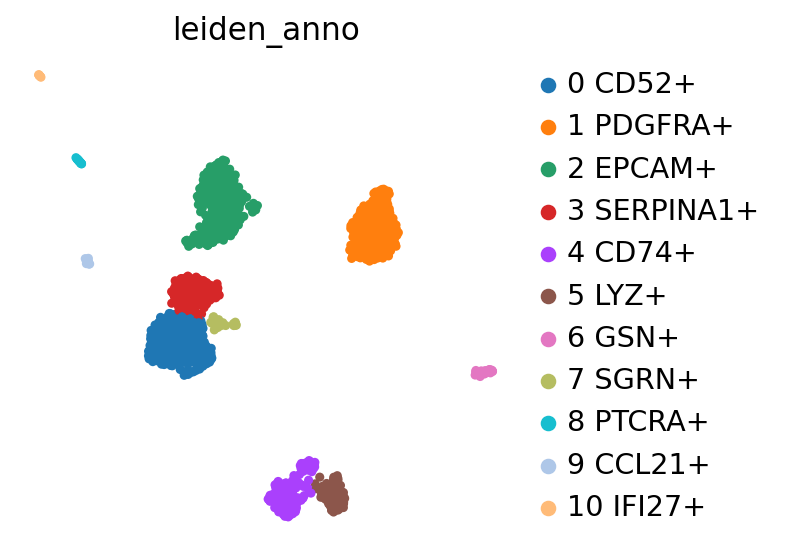

In [41]:
sc.pl.umap(Human, wspace=0.35, frameon=False,
           color=['leiden_anno'], save='_Fig 5E_human_leiden.pdf')

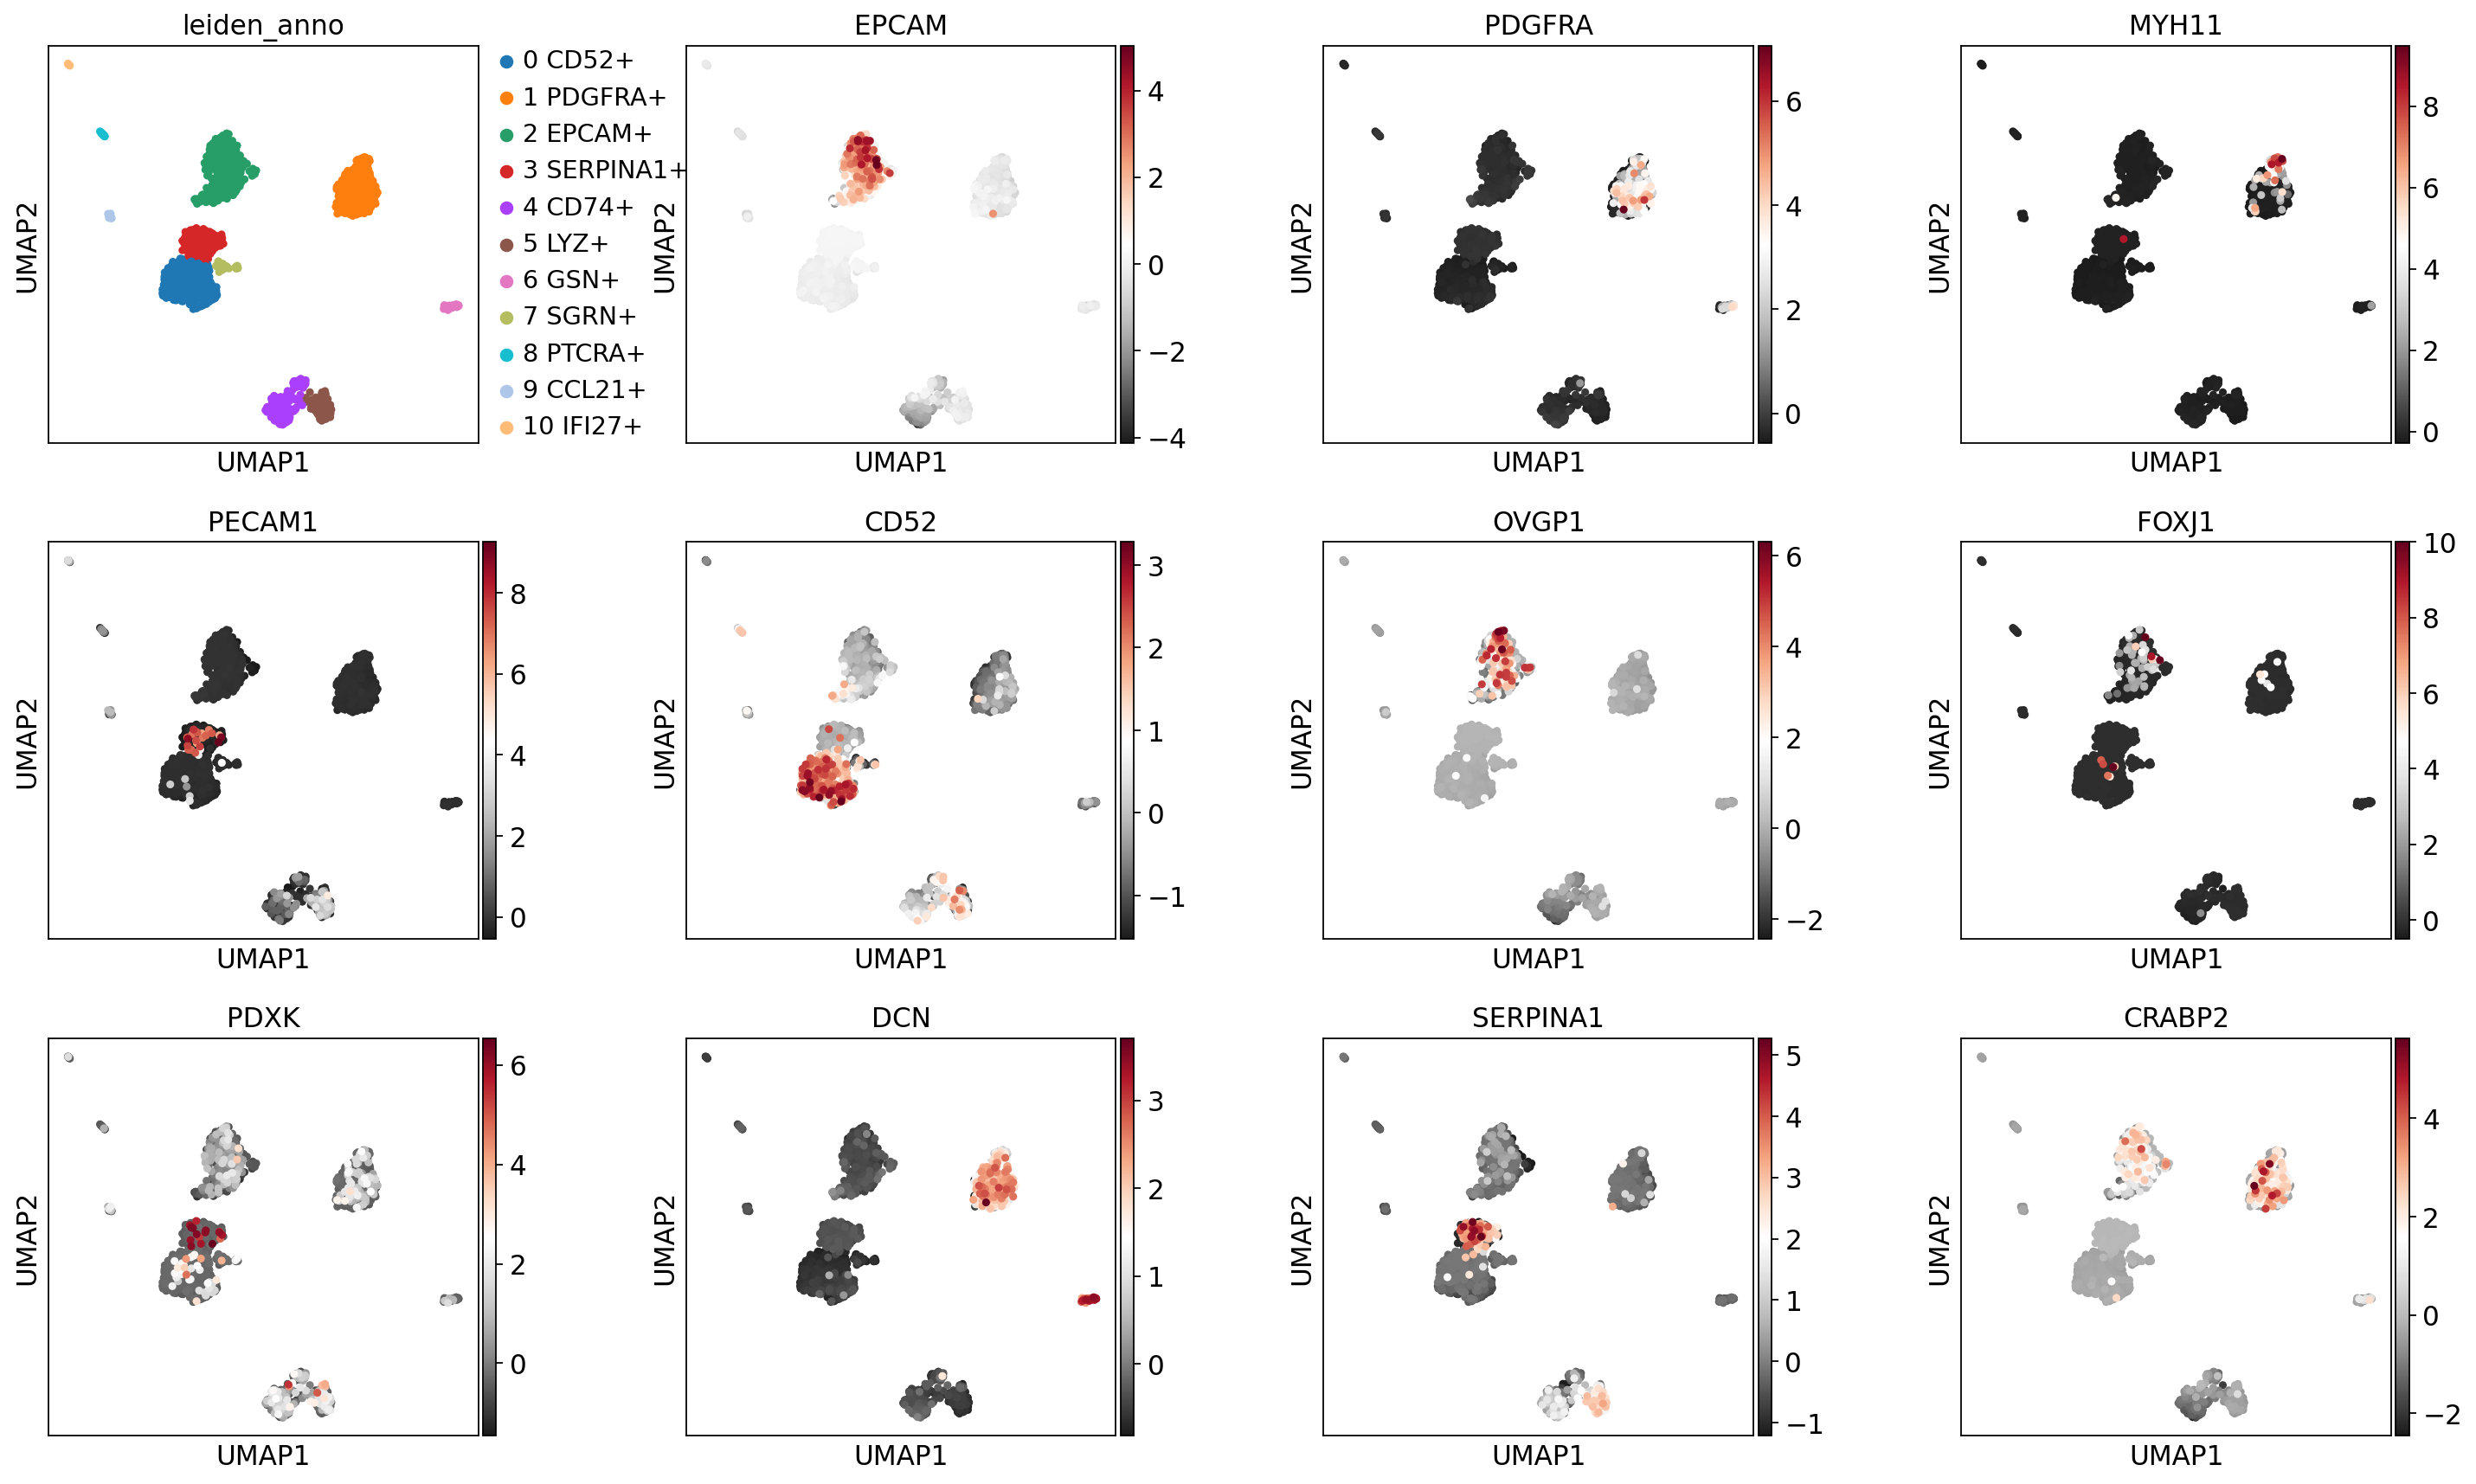

In [42]:
sc.pl.umap(Human, wspace=0.35, 
           color=['leiden_anno', 'EPCAM', 'PDGFRA', 'MYH11','PECAM1', 'CD52',
                  'OVGP1', 'FOXJ1',  'PDXK', 'DCN', 'SERPINA1', 'CRABP2'], 
           color_map='RdGy_r',
           save='_all markers.pdf')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/opt/conda/envs/hub_v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


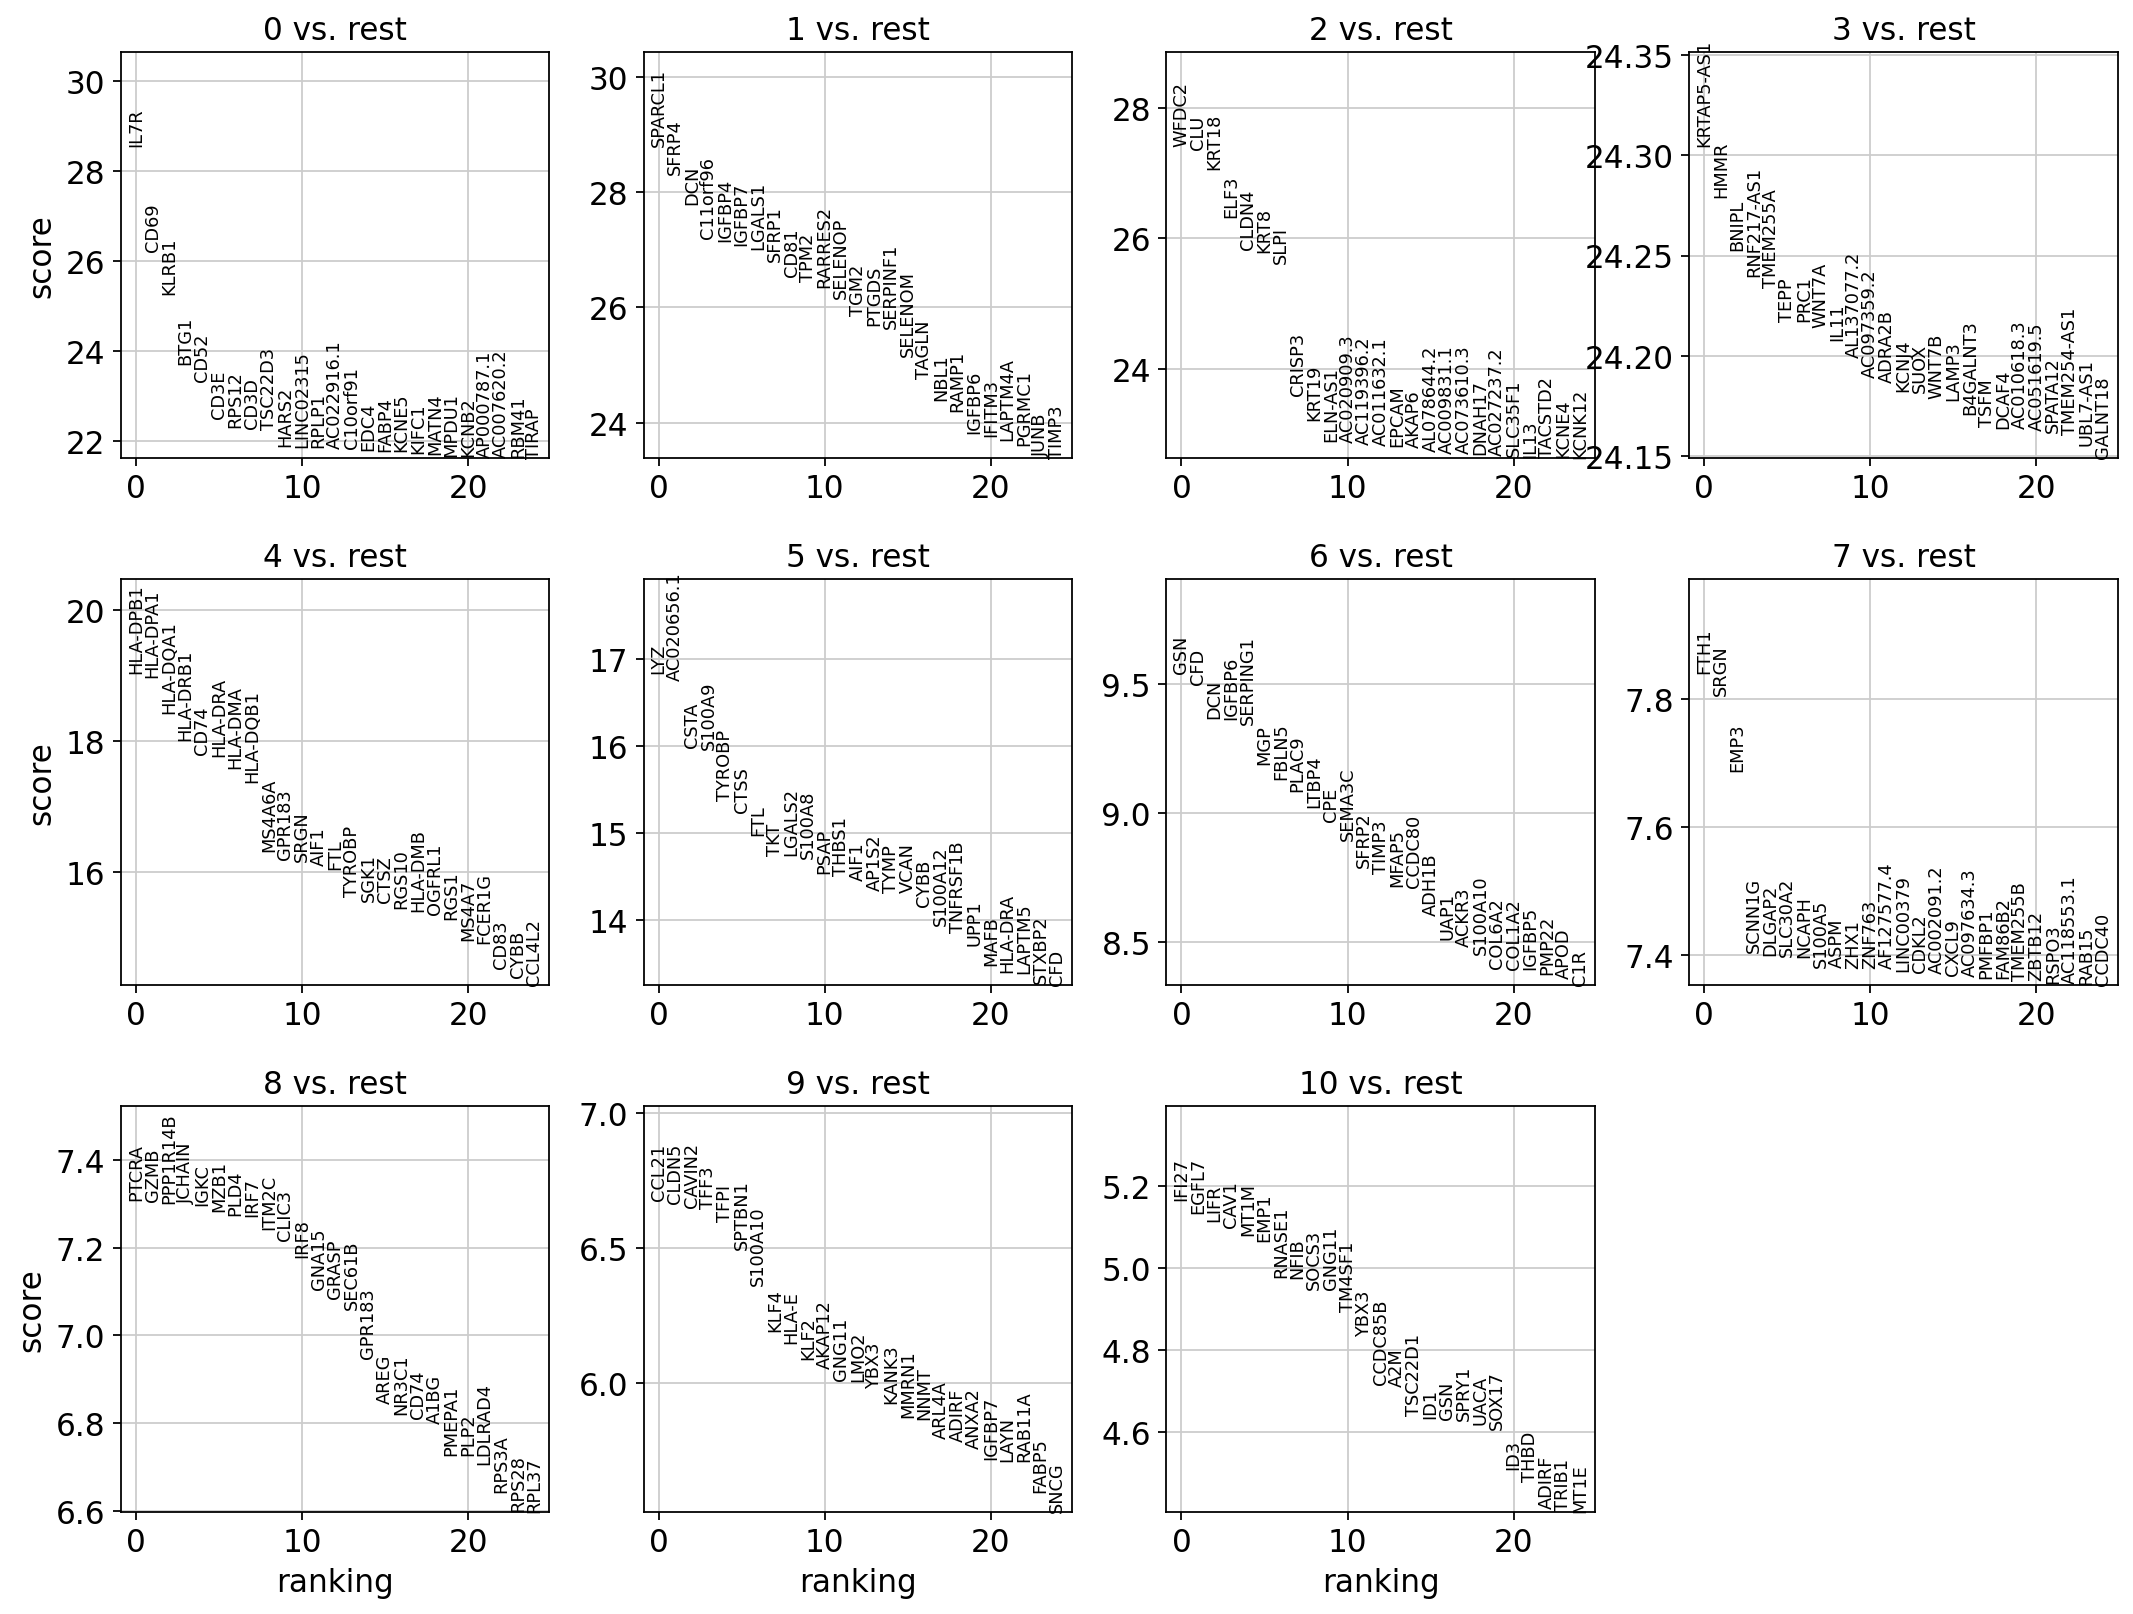

0         1      2           3         4           5         6       7  \
0   IL7R   SPARCL1  WFDC2  KRTAP5-AS1  HLA-DPB1         LYZ       GSN    FTH1   
1   CD69     SFRP4    CLU        HMMR  HLA-DPA1  AC020656.1       CFD    SRGN   
2  KLRB1       DCN  KRT18       BNIPL  HLA-DQA1        CSTA       DCN    EMP3   
3   BTG1  C11orf96   ELF3  RNF217-AS1  HLA-DRB1      S100A9    IGFBP6  SCNN1G   
4   CD52    IGFBP4  CLDN4    TMEM255A      CD74      TYROBP  SERPING1  DLGAP2   

          8       9     10  
0     PTCRA   CCL21  IFI27  
1      GZMB   CLDN5  EGFL7  
2  PPP1R14B  CAVIN2   LIFR  
3    JCHAIN    TFF3   CAV1  
4      IGKC    TFPI   MT1M

In [43]:
sc.tl.rank_genes_groups(Human, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(Human, n_genes=25, sharey=False)
pd.DataFrame(Human.uns['rank_genes_groups']['names']).head(5)

In [44]:
result = Human.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(20)

0_n            0_p       1_n            1_p         2_n  \
0         IL7R  2.272648e-179   SPARCL1  2.290537e-182       WFDC2   
1         CD69  1.523444e-151     SFRP4  3.178945e-176         CLU   
2        KLRB1  1.008651e-140       DCN  4.787729e-170       KRT18   
3         BTG1  3.606872e-124  C11orf96  6.224147e-163        ELF3   
4         CD52  2.115085e-120    IGFBP4  2.723379e-162       CLDN4   
5         CD3E  4.619842e-112    IGFBP7  1.928408e-161        KRT8   
6        RPS12  3.305650e-110    LGALS1  1.113058e-160        SLPI   
7         CD3D  5.789353e-110     SFRP1  2.893453e-158      CRISP3   
8      TSC22D3  1.142320e-109      CD81  2.954574e-155       KRT19   
9        HARS2  4.663090e-106      TPM2  3.920147e-154     ELN-AS1   
10   LINC02315  5.221990e-106   RARRES2  4.730391e-153  AC020909.3   
11       RPLP1  5.319385e-106   SELENOP  8.087562e-151  AC119396.2   
12  AC022916.1  8.738324e-106      TGM2  1.410936e-147  AC011632.1   
13    C10orf91  1.063141e-105     PTGDS  1.261502e-145       EPCAM   
14        EDC4  3.117912e-105  SERPINF1  6.472500e-145       AKAP6   
15       FABP4  5.540876e-105   SELENOM  1.485498e-139  AL078644.2   
16       KCNE5  5.708939e-105     TAGLN  1.488165e-135  AC009831.1   
17       KIFC1  1.033779e-104      NBL1  1.851080e-131  AC073610.3   
18       MATN4  1.683335e-104     RAMP1  2.667507e-129      DNAH17   
19       MPDU1  5.278832e-104    IGFBP6  2.441141e-125  AC027237.2   

              2_p         3_n            3_p       4_n           4_p  ...  \
0   1.817620e-165  KRTAP5-AS1  1.755196e-130  HLA-DPB1  7.251859e-81  ...   
1   7.296867e-165        HMMR  3.253664e-130  HLA-DPA1  2.680185e-80  ...   
2   2.833270e-161       BNIPL  6.166700e-130  HLA-DQA1  6.768754e-76  ...   
3   9.242109e-153  RNF217-AS1  8.515215e-130  HLA-DRB1  1.430949e-72  ...   
4   3.187447e-147    TMEM255A  9.700570e-130      CD74  6.171150e-71  ...   
5   1.061234e-146        TEPP  1.452723e-129   HLA-DRA  1.006933e-70  ...   
6   7.817287e-145        PRC1  1.462213e-129   HLA-DMA  3.008720e-69  ...   
7   3.555509e-123       WNT7A  1.565672e-129  HLA-DQB1  1.094491e-67  ...   
8   3.655785e-119        IL11  1.824475e-129    MS4A6A  6.833515e-60  ...   
9   5.180224e-116  AL137077.2  2.246868e-129    GPR183  4.660408e-59  ...   
10  7.497781e-116  AC097359.2  2.858305e-129      SRGN  7.177705e-59  ...   
11  1.305801e-115      ADRA2B  3.030599e-129      AIF1  2.080340e-58  ...   
12  2.104146e-115       KCNJ4  3.384832e-129       FTL  5.390555e-58  ...   
13  3.153925e-115        SUOX  3.418006e-129    TYROBP  3.587267e-55  ...   
14  4.004783e-115       WNT7B  3.707378e-129      SGK1  1.445595e-54  ...   
15  1.803835e-114       LAMP3  3.780392e-129      CTSZ  1.766982e-54  ...   
16  3.411033e-114    B4GALNT3  4.476416e-129     RGS10  7.501825e-54  ...   
17  3.626910e-114        TSFM  5.164358e-129   HLA-DMB  1.321041e-53  ...   
18  5.650759e-114       DCAF4  5.283142e-129    OGFRL1  2.916857e-53  ...   
19  6.171336e-114  AC010618.3  5.300332e-129      RGS1  9.535741e-53  ...   

         6_n           6_p         7_n           7_p       8_n           8_p  \
0        GSN  1.372407e-21        FTH1  4.460787e-15     PTCRA  2.683642e-13   
1        CFD  2.071357e-21        SRGN  5.887209e-15      GZMB  2.748469e-13   
2        DCN  7.210309e-21        EMP3  1.497827e-14  PPP1R14B  2.843756e-13   
3     IGFBP6  7.730957e-21      SCNN1G  1.316277e-13    JCHAIN  2.853461e-13   
4   SERPING1  9.125009e-21      DLGAP2  1.352078e-13      IGKC  2.942285e-13   
5        MGP  3.924684e-20     SLC30A2  1.374016e-13      MZB1  3.275084e-13   
6      FBLN5  6.664824e-20       NCAPH  1.400053e-13      PLD4  3.475668e-13   
7      PLAC9  1.037538e-19      S100A5  1.562581e-13      IRF7  3.535160e-13   
8      LTBP4  1.802698e-19        ASPM  1.566769e-13     ITM2C  4.435707e-13   
9        CPE  2.975477e-19        ZHX1  1.579397e-13     CLIC3  5.286582e-13   
10    SEMA3C  5.789303e-19      ZNF763  1.

In [45]:
Df_Pvalue = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
for group in groups for key in ['names', 'pvals']})

In [46]:
Df_Pvalue.to_csv('TableS5_Df_Pvalue_Human_ClusterMarkers.csv')

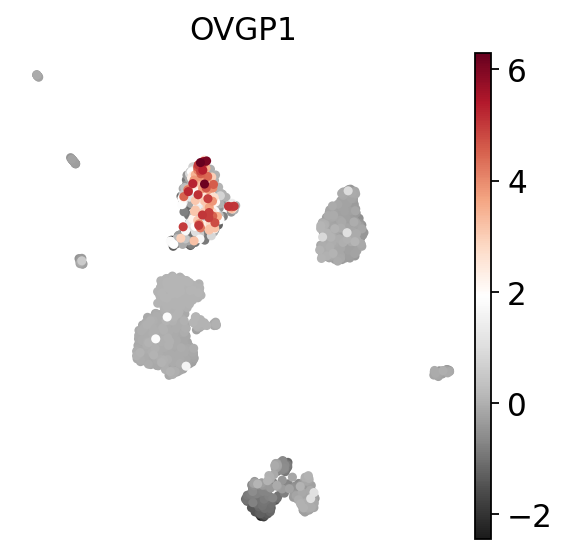

In [47]:
sc.pl.umap(Human, wspace=0.35, 
           color=['OVGP1'], frameon=False,
          color_map='RdGy_r', 
save='_OVGP1.pdf')

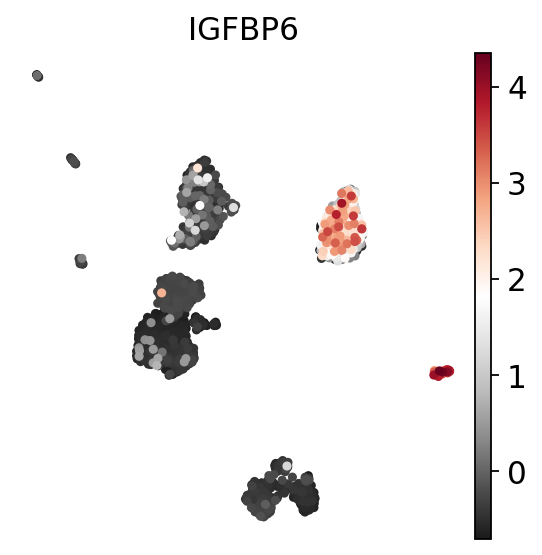

In [48]:
sc.pl.umap(Human, wspace=0.35, 
           color=['IGFBP6'], frameon=False,
          color_map='RdGy_r', 
save='_IGFBP6.pdf')

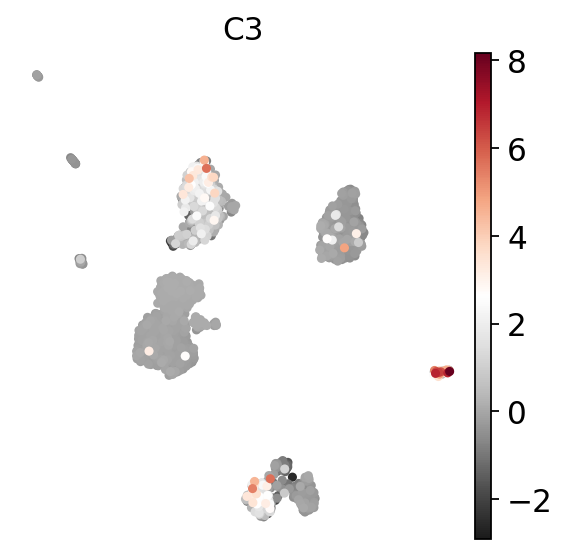

In [49]:
sc.pl.umap(Human, wspace=0.35, 
           color=['C3'], frameon=False,
          color_map='RdGy_r', 
save='_C3.pdf')

In [50]:
Human

AnnData object with n_obs × n_vars = 1790 × 14928
    obs: 'Clusters', '_X', '_Y', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'leiden_anno'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_anno_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [51]:
Human.write('./Human_analyzed.h5ad')

In [52]:
Human = sc.read('./Human_analyzed.h5ad')